# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [105]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [106]:
from sklearn.datasets import load_boston

In [107]:
boston = load_boston()

In [108]:
#X = boston["data"]
X = pd.DataFrame(data=boston["data"], columns=boston['feature_names'])
y = pd.Series(boston["target"])

In [109]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [110]:
z = np.random.normal(loc=5, scale=3, size=100000)
(z**2).mean()

33.95498391241003

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [111]:
X = pd.DataFrame(data=boston["data"], columns=boston['feature_names'])
y = pd.Series(boston["target"])

def compute_biase_variance(clf, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    ### your code here
    # блок инициализации
    result = np.zeros((X.shape[0], 4))
    result = pd.DataFrame(result)
    bias = 0
    variance = 0
    mse = 0

    for i in range(num_runs):
        np.random.seed(i)
        # выделение бустрапа и out-of-bag значений
        bs = np.random.randint(X.shape[0], size=X.shape[0])
        inv_bs = np.setdiff1d(np.arange(X.shape[0]), bs)
        # обучение регрессора
        clf.fit(X.iloc[bs], y.iloc[bs])
        pred = clf.predict(X.iloc[inv_bs])
        # подготовка данных для последующих расчётов    
        result.iloc[inv_bs, 0] += 1
        result.iloc[inv_bs, 1] += pred
        result.iloc[inv_bs, 2] += pred**2
        result.iloc[inv_bs, 3] += (pred - y.iloc[inv_bs])**2
    
    #Определение не нулевых строк
    valid_in = result.iloc[:, 0] > 0
    # подготовка значений
    E_Mu_X = result.loc[valid_in, 1] / result.loc[valid_in, 0]
    #Вычисление смещения
    bias = (E_Mu_X - y.loc[valid_in])**2
    bias = np.mean(bias)
    #Вычисление смещения
    variance = result.loc[valid_in, 2]/result.loc[valid_in, 0] - (E_Mu_X)**2
    variance = np.mean(variance)
    #Вычисление ошибки
    error = result.loc[valid_in, 3] / result.loc[valid_in, 0]
    error = np.mean(error)
    
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

clf = LinearRegression()
dtr = DecisionTreeRegressor()
rfr = RandomForestRegressor()
num_runs = 10

def print_func(clf, clf_name):
        bias, variance, error = compute_biase_variance(clf, X, y, num_runs)
        print(f'{clf_name}\t Смещение: {bias},\t Разброс: {variance},\t Ошибка: {error}')

print_func(clf, 'LinearRegression')
print_func(dtr, 'DecisionTreeRegressor')
print_func(rfr, 'RandomForestRegressor')

LinearRegression	 Смещение: 24.208692818315935,	 Разброс: 0.6066525122886902,	 Ошибка: 24.815345330604604
DecisionTreeRegressor	 Смещение: 15.484112719558713,	 Разброс: 8.968214377946946,	 Ошибка: 24.45232709750565
RandomForestRegressor	 Смещение: 12.450016157689964,	 Разброс: 1.5148092395346275,	 Ошибка: 13.96482539722458


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__
По результатам моделирования видно следующее:  
&nbsp;&nbsp;&nbsp;– линейная модель обладает наименьшим разбросом, однако она не может приблизиться к нелинейной зависимости в данных;  
&nbsp;&nbsp;&nbsp;– решающие деревья лучше подстраивается под зависимости исследуемого датасета т.е. смещение алгоритма по сравнению с линейной моделью меньше, но из-за склонности алгоритма к переобучению значительно увеличивается разброс модели. суммарная ошибка по сравнению с линейной моделью практически не изменилась;  
&nbsp;&nbsp;&nbsp;– случайны лес на данной выборке демонстрирует наилучшие значения как по смещению, так и по разбросу, суммарная ошибка снижена приблезительно в два раза;

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

In [113]:
from sklearn.ensemble import BaggingRegressor
b_clf = BaggingRegressor(LinearRegression(), n_estimators=10, random_state=0)
b_dtr = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10, random_state=0)
b_rfr = BaggingRegressor(RandomForestRegressor(), n_estimators=10, random_state=0)

print_func(b_clf, 'BaggingLinearRegression\t')
print_func(b_dtr, 'BaggingDecisionTreeRegressor')
print_func(b_rfr, 'baggingRandomForestRegressor')

BaggingLinearRegression		 Смещение: 24.126348400745023,	 Разброс: 0.5988006565887153,	 Ошибка: 24.72514905733373
BaggingDecisionTreeRegressor	 Смещение: 12.905657500795783,	 Разброс: 2.279250556806893,	 Ошибка: 15.184908057602684
baggingRandomForestRegressor	 Смещение: 13.127924194047084,	 Разброс: 0.8504589493442736,	 Ошибка: 13.97838314339136


__Your answer here:__
Бэггинг в теории может уменьшить разброс в N раз, однако из-за статистической связи между моделями это условие не выполняется.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [114]:
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import scatter

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    ### your code here
    #X_train, y_train, X_test, y_test = train_test_split(X, y, test)
    np.random.seed(42)
    colors = ['red','green', 'blue','orange','yellow','pink','magenta', 'grey', 'brown','purple']
    test_ind = np.random.choice(np.arange(X.shape[0]), size=num_test_objects, replace=False )
    train_ind = np.setdiff1d(np.arange(X.shape[0]), test_ind)
    
    X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
    X_test, y_test = X.iloc[test_ind], y.iloc[test_ind]
    
    for i in range(num_runs):
        #np.random.seed(i)
        # выделение бустрапа и num_test_objects значений
        bs = np.random.randint(X_train.shape[0], size=X_train.shape[0])
        inv_bs = np.setdiff1d(np.arange(X_train.shape[0]), bs)
        # обучение регрессора
        regressor.fit(X_train.iloc[bs], y_train.iloc[bs])
        scatter(x=np.arange(10), y=regressor.predict(X_test), c=colors)
        pd
        
    scatter(x=np.arange(10), y=y_test, c='black', s=80)
    plt.title(title)
    plt.grid('minor')
    plt.ylim([0, 55])

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

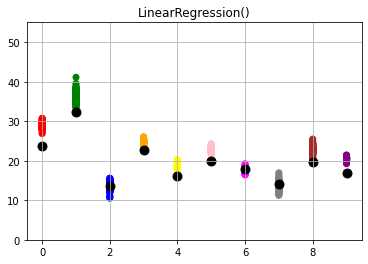

In [115]:
plot_predictions(clf, X, y, num_runs=100, num_test_objects=10, title="LinearRegression()")

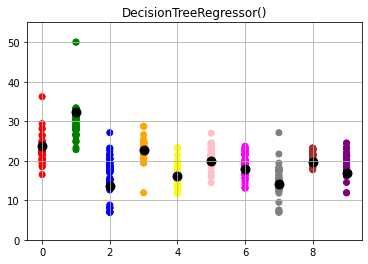

In [116]:
plot_predictions(dtr, X, y, num_runs=100, num_test_objects=10, title="DecisionTreeRegressor()")

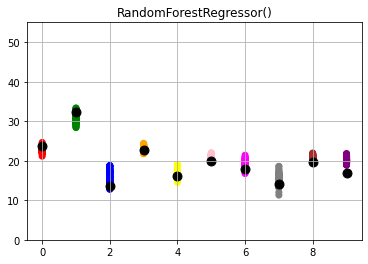

In [117]:
plot_predictions(rfr, X, y, num_runs=100, num_test_objects=10, title="RandomForestRegressor()")

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

Линейный регрессор:
– смещение в моделях большое,чёрные кружки иногда совсем не пересекаются с цветными; Разброс цветных кружков имеет невысокие значения; 

Решающее дерево:
– Черные кружки ближе к середине разброса цветных(умеренное смещение); разброс цветных кружков заметно выше чем у других регрессоров;

Случайный лес:
   – цветные кружки лежат ближе к чёрным(умеренное смещение, близко к значению решающего дерева); цветные кружки имеют низкий разброс;

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [118]:
### your code here
import itertools
bias_ = []
variance_ = []
for i in range(1, 11):
    dtr = DecisionTreeRegressor(max_depth=i)
    bias, variance, error = compute_biase_variance(dtr, X, y, num_runs=10)
    bias_.append(bias)
    dtr = DecisionTreeRegressor(max_features=i)
    bias, variance, error = compute_biase_variance(dtr, X, y, num_runs=10)
    variance_.append(variance)

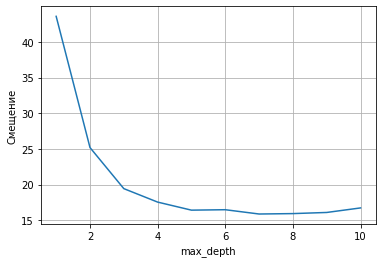

In [119]:
plt.plot(range(1, 11), bias_)
plt.xlabel('max_depth');
plt.ylabel('Смещение');
plt.grid()

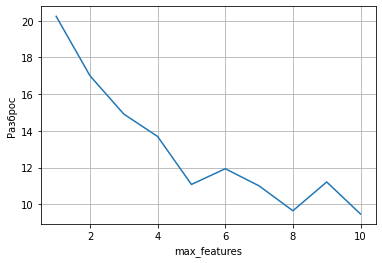

In [120]:
plt.plot(range(1, 11), variance_)
plt.xlabel('max_features');
plt.ylabel('Разброс');
plt.grid()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [121]:
from sklearn.ensemble import GradientBoostingRegressor
b_n_v = pd.DataFrame(columns=['bias', 'variance'],index=list(2**np.arange(1, 10)))
g_b_r = pd.DataFrame(columns=['bias', 'variance'], index=list(2**np.arange(1, 10)))
### your code here
for i in 2**np.arange(1, 10):
    dtr = RandomForestRegressor(n_estimators=i)
    bias, variance, error = compute_biase_variance(dtr, X, y, num_runs=10)
    b_n_v['bias'].loc[i]=bias
    b_n_v['variance'].loc[i]=variance
    gbr = GradientBoostingRegressor(n_estimators=i)
    bias, variance, error = compute_biase_variance(gbr, X, y, num_runs=10)
    g_b_r['bias'].loc[i]=bias
    g_b_r['variance'].loc[i]=variance

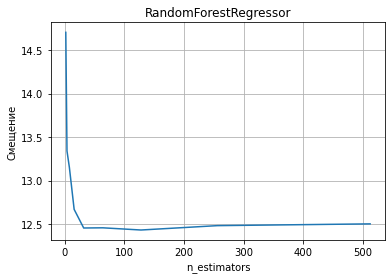

In [122]:
plt.plot(2**np.arange(1, 10), b_n_v['bias'])
plt.title('RandomForestRegressor')
plt.xlabel('n_estimators');
plt.ylabel('Смещение');
plt.grid()

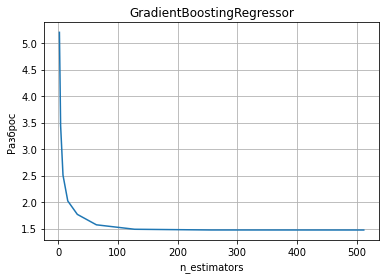

In [123]:
plt.plot(2**np.arange(1, 10), b_n_v['variance'])
plt.title('GradientBoostingRegressor')
plt.xlabel('n_estimators');
plt.ylabel('Разброс');
plt.grid()

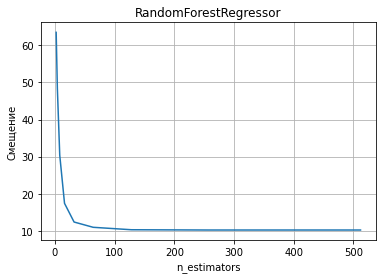

In [124]:
plt.plot(2**np.arange(1, 10), g_b_r['bias'])
plt.title('RandomForestRegressor')
plt.xlabel('n_estimators');
plt.ylabel('Смещение');
plt.grid()

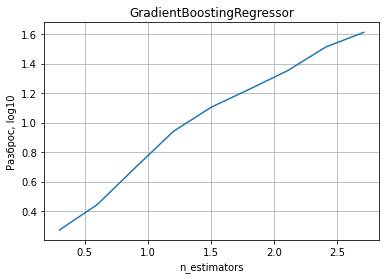

In [125]:
plt.plot(np.log10(2**np.arange(1, 10)), g_b_r['variance'])
plt.title('GradientBoostingRegressor')
plt.xlabel('n_estimators');
plt.ylabel('Разброс, log10');
plt.grid()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__
Решующее дерево:  
– с увеличением максимальной глубины(max_depth) смещение снижается до max_depth=6, после выходит на плато и послеmax_depth=8 снова возрастает из-за переобучения;
– с увеличением число признаков, по которым ищется разбиение(max_features)  разброс снижается.

Случайный лес:  
– с увеличением числа деревьев(n_estimators) по закону 2^n происходит снижение смещения и разброса, после значения n_estimators=256 значения не изменяются; смещение имеет явный минимум на значении n_estimators=128;

Градиентный бустинг:  

– с увеличением максимальноuj количество итераций, при котором бустинг прекращается(n_estimators). В случае идеальной подгонки процедура обучения прекращается досрочноn_estimators по закону 2^n происходит снижение смещения и достигается минимальное значение при n_estimators=256 ;

– с увеличением n_estimators по закону 2^n происходит увеличение разброса по логарифмическому закону;


Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.